In [45]:
#NB: Kaggle requires phone verification to use the internet or a GPU. If you haven't done that yet, the cell below will fail
#    This code is only here to check that your internet is enabled. It doesn't do anything else.
#    Here's a help thread on getting your phone number verified: https://www.kaggle.com/product-feedback/135367

import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [46]:
!pip install -Uq fastai

In [47]:
from pathlib import Path

data_root=Path('/data/wood-species/hand-cleaned')
data_dirs = [x for x in data_root.iterdir() if x.is_dir()]


In [71]:
from fastai.vision.all import *

class WoodPicture:
    def __init__(self, name, path, dataset):
        self.name = name
        self.path = path
        self.dataset = dataset

    def image(self):
        return Image.open(self.path)

class WoodPictures:
    def __init__(self, path):
        self.path = path
        self.name = path.name
        self.image_files = [x for x in path.iterdir() if self.use_file(x)]
                                                                                                                  
    def use_file(self, f):
        if not f.is_file(): return False 
        if not f.match('*.jpg'): return False
        if f.match('*web.*') or f.match('*end grain*'): return False
        return True

    def images(self):
        images = []
        for x in self.image_files:
            dataset = 'valid' if random.random() < 0.2 else 'train'
            images.append(WoodPicture(self.name, x, dataset))
        return images

In [72]:
# Load all images
woods = [WoodPictures(x) for x in data_dirs]
len(woods)

423

In [73]:
#from tqdm.notebook import tqdm

#for wood in tqdm(woods, desc="Checking woods for broken images"):
#    for image in wood.images():
#        if not verify_image(image.path):
#            print("- Broken image:", image.path)

In [74]:
# wood = woods[10]
# print(f"Name: {wood.name}")
# images = wood.images()
# images[1].image().to_thumb(512,512)

In [75]:
training_woods = woods[0:10]
images = [x for wood in training_woods for x in wood.images()]
len(images)

648

In [76]:
# Check train/validation dataset split
from collections import Counter
Counter([i.dataset for i in images])

Counter({'train': 526, 'valid': 122})

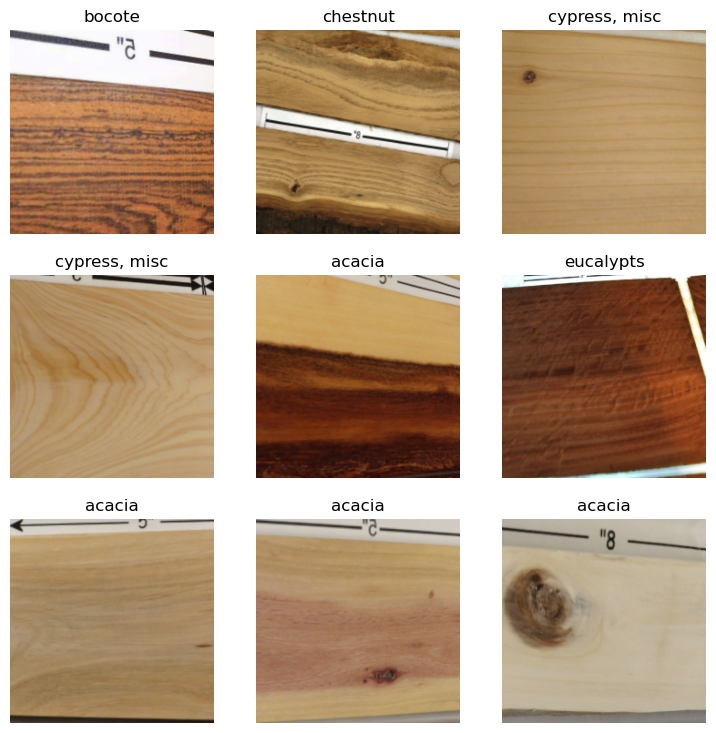

In [80]:
def get_images(x):
    return x

def get_path(x):
    return x.path
    
def get_name(x):
    return x.name

dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_images,
    get_x=get_path,
    get_y=get_name,
    splitter=FuncSplitter(lambda o: o.dataset == 'valid'),
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms(),
).dataloaders(images, bs=32)

dls.show_batch(max_n=9, nrows=3)

In [81]:
learn = vision_learner(dls, resnet50, metrics=error_rate)
learn.fine_tune(5)

epoch,train_loss,valid_loss,error_rate,time
0,2.741432,1.746124,0.483607,00:41


epoch,train_loss,valid_loss,error_rate,time
0,1.495856,1.388537,0.401639,00:41
1,1.349798,1.506553,0.262295,00:41
2,1.131637,1.449710,0.319672,00:42
3,0.937482,1.229787,0.262295,00:41
4,0.836406,1.198097,0.254098,00:41


In [82]:
learn.fine_tune(5)

epoch,train_loss,valid_loss,error_rate,time
0,0.535977,1.310151,0.286885,00:41


epoch,train_loss,valid_loss,error_rate,time
0,0.551508,1.085005,0.254098,00:41
1,0.563955,1.460060,0.295082,00:41
2,0.549529,1.084167,0.262295,00:41
3,0.489372,0.914864,0.221311,00:41
4,0.416006,0.891913,0.221311,00:41


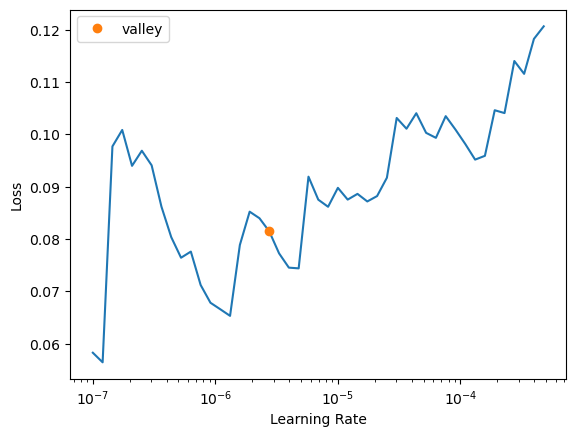

In [93]:
lr = learn.lr_find()

In [95]:
learn.fit_one_cycle(5, lr_max = 0.00000316227)

epoch,train_loss,valid_loss,error_rate,time
0,0.112452,0.685377,0.147541,00:40
1,0.103450,0.703279,0.139344,00:40
2,0.096622,0.650747,0.131148,00:40
3,0.086748,0.678618,0.147541,00:41
4,0.085380,0.679370,0.139344,00:40


In [96]:
learn.fit_one_cycle(5, lr_max = 1e-06)

epoch,train_loss,valid_loss,error_rate,time
0,0.073631,0.669767,0.147541,00:41
1,0.065162,0.668331,0.131148,00:41
2,0.100432,0.672409,0.131148,00:40
3,0.096046,0.673834,0.147541,00:40
4,0.083986,0.674053,0.131148,00:41


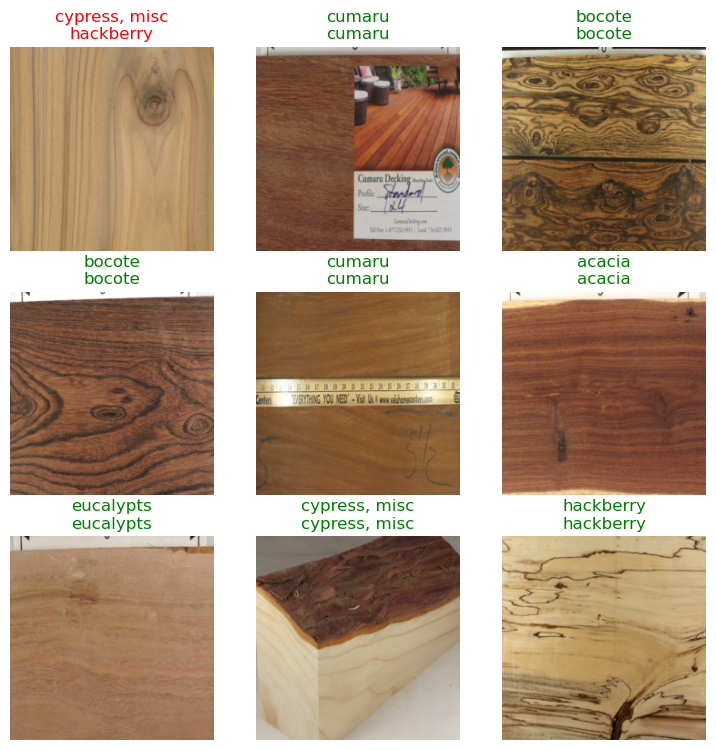

In [97]:
learn.show_results()

In [98]:
test_woods = ["bocote","chestnut"]
for test_wood in test_woods:
    test_dir = Path("../../test-images") / test_wood
    for x in test_dir.iterdir():
        if x.is_file():
            image = PILImage.create(x)
            name, _, _ = learn.predict(image)
            print(f"{x}: expected '{test_wood}', got '{name}'")

../../test-images/bocote/bocCloseup-small.jpg: expected 'bocote', got 'bocote'


../../test-images/bocote/bocote-v2.jpg: expected 'bocote', got 'bocote'


../../test-images/bocote/bocBF-small.jpg: expected 'bocote', got 'bocote'


../../test-images/bocote/bocote-1000x500-2.jpg: expected 'bocote', got 'bocote'


../../test-images/chestnut/wormy-chestnut@2x.webp: expected 'chestnut', got 'chestnut'


../../test-images/chestnut/istockphoto-182856415-1024x1024.jpg: expected 'chestnut', got 'chestnut'


../../test-images/chestnut/reclaimed-barnwood-farm-table_04.jpg: expected 'chestnut', got 'eucalypts'
